# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:

from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from src.datasets.rb_fpa_snapshots_ee_plateau import RBFPASnapshotsEEPlateau
from src.datasets.rb_fpa_snapshots_ee_plateau2 import RBFPASnapshotsEEPlateau2
from src.utils.frequency_utils import get_fft_of_DataArray
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_nmf_event_composition, plot_avg_component_weight, plot_component_distribution
from src.models import nmf
from src.utils.sort_utils import generate_sorted_value_dict

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

# Read the (clean) MP3 file

In [20]:
context_path = Path("../data/RB_snapshot_context.csv")
mp3_fpa_df = pd.read_csv(context_path)

# for easier execution
mp3_fpa_df['Timestamp_PIC'] = mp3_fpa_df['date']

mp3_fpa_df['I_Q_kA'] = mp3_fpa_df["I_Q_M"].apply(lambda x: np.round(x / 1e3)*1e3)
mp3_fpa_df['dI_dt_kA'] = mp3_fpa_df["dI_dt_from_data"].apply(lambda x: np.round(x))

mp3_fpa_df['datetime'] = pd.to_datetime(mp3_fpa_df['date'])
mp3_fpa_df['year'] = mp3_fpa_df['datetime'].apply(lambda x: x.year)
mp3_fpa_df['month'] = mp3_fpa_df['datetime'].apply(lambda x: x.month)
mp3_fpa_df['day'] = mp3_fpa_df['datetime'].apply(lambda x: x.day)

# Read metadata

In [4]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,Short magnet ID,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,3288,14.0,3.0,01B,02B8,11488.0,NaN,NaN,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,2256,14.0,2.0,01E,02C0,10622.0,NaN,NaN,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,2330,14.0,2.0,01E,02C9,12427.0,NaN,NaN,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,2319,14.0,2.0,01E,02C9,11155.0,NaN,NaN,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,1296,14.0,1.0,01E,02B8,11782.0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,3123,14.0,3.0,01B,02G,12645.0,NaN,NaN,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,1062,14.0,1.0,01B,02B5,12379.0,NaN,NaN,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,2061,14.0,2.0,01B,02K,11757.0,NaN,NaN,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,3172,14.0,3.0,01B,02G,11656.0,NaN,NaN,0,0


# Read position map

In [5]:
pos_map_path = Path("../data/circuit_sort.csv")
df_pos_map = pd.read_csv(pos_map_path)

In [6]:
df_pos_map = df_pos_map.set_index(['Circuit', 'El. Quench Position', 'Phys. Quench Position']) # allows faster indexing

# Load Data

In [7]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20221123_RBFPASnapshotsEEPlateau")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20221123_RBFPASnapshotsEEPlateau2")

dataset_creator_1EE = RBFPASnapshotsEEPlateau()
dataset_creator_2EE = RBFPASnapshotsEEPlateau2()

all_fpa_identifiers = mp3_fpa_df.fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation'])

dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_2EE,
                                       drop_data_vars=['simulation'])

max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)
dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE.data, cutoff_frequency=max_freq)

# postprocess fft data
data_1EE_ff_scaled = np.array([dataset_creator_1EE.log_scale_data(x) for x in dataset_1EE_fft.data])
data_2EE_ff_scaled = np.array([dataset_creator_2EE.log_scale_data(x) for x in dataset_2EE_fft.data])
data_1EE = np.nan_to_num(data_1EE_ff_scaled.reshape(-1, np.shape(data_1EE_ff_scaled)[2]))
data_2EE = np.nan_to_num(data_2EE_ff_scaled.reshape(-1, np.shape(data_2EE_ff_scaled)[2]))

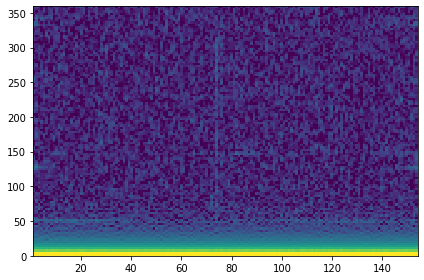

In [8]:
fig, ax = plt.subplots()
plot_position_frequency_map(ax, dataset_1EE_fft[{'event': 30}].values, dataset_1EE_fft.frequency)

# Non-negative components - NMF

In [9]:
fpa_identifiers = all_fpa_identifiers[np.isin(all_fpa_identifiers, dataset_1EE.event.values)]

use_fpa_identifier = False
if use_fpa_identifier:
    # provide fpa_identifier
    fpa_identifier = 'RB_RB.A23_1620923593800000000'
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
else: 
    # provide event_index 
    event_idex =40 #30
    dataset_fft_cut = dataset_1EE_fft.loc[{'event': fpa_identifiers}]
    fpa_identifier =  dataset_fft_cut[{'event': event_idex}].event.values

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['date'].values[0]
event_idex, fpa_identifier, date

(40,
 array('RB_RB.A78_1647014532220000000', dtype='<U29'),
 '2022-03-11 17:02:12.220000+01:00')

## 1st Energy Extraction Plateau

In [10]:
n_components = 5
W_1EE, H_1EE, n_iter = nmf.non_negative_factorization(data_1EE, n_components=n_components, init='nndsvd', tol=1e-3, l1_ratio=0.5,  regularization='both', alpha=1)

max_H = H_1EE.max(axis=1, keepdims=True)
H_1EE_processed = H_1EE / max_H
component_weights_1EE = (W_1EE * np.expand_dims(max_H.T, axis=0))[0]

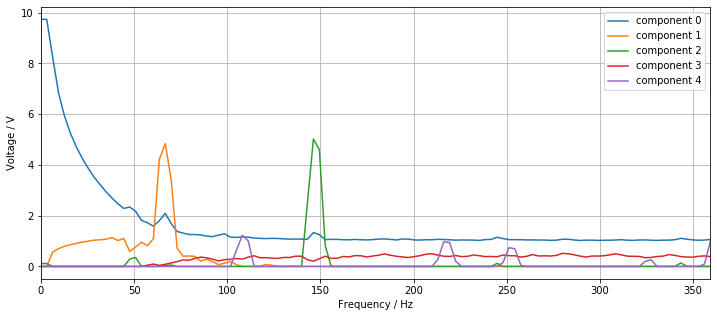

In [11]:
plot_nmf_components(H_1EE, dataset_1EE_fft)

### Check components

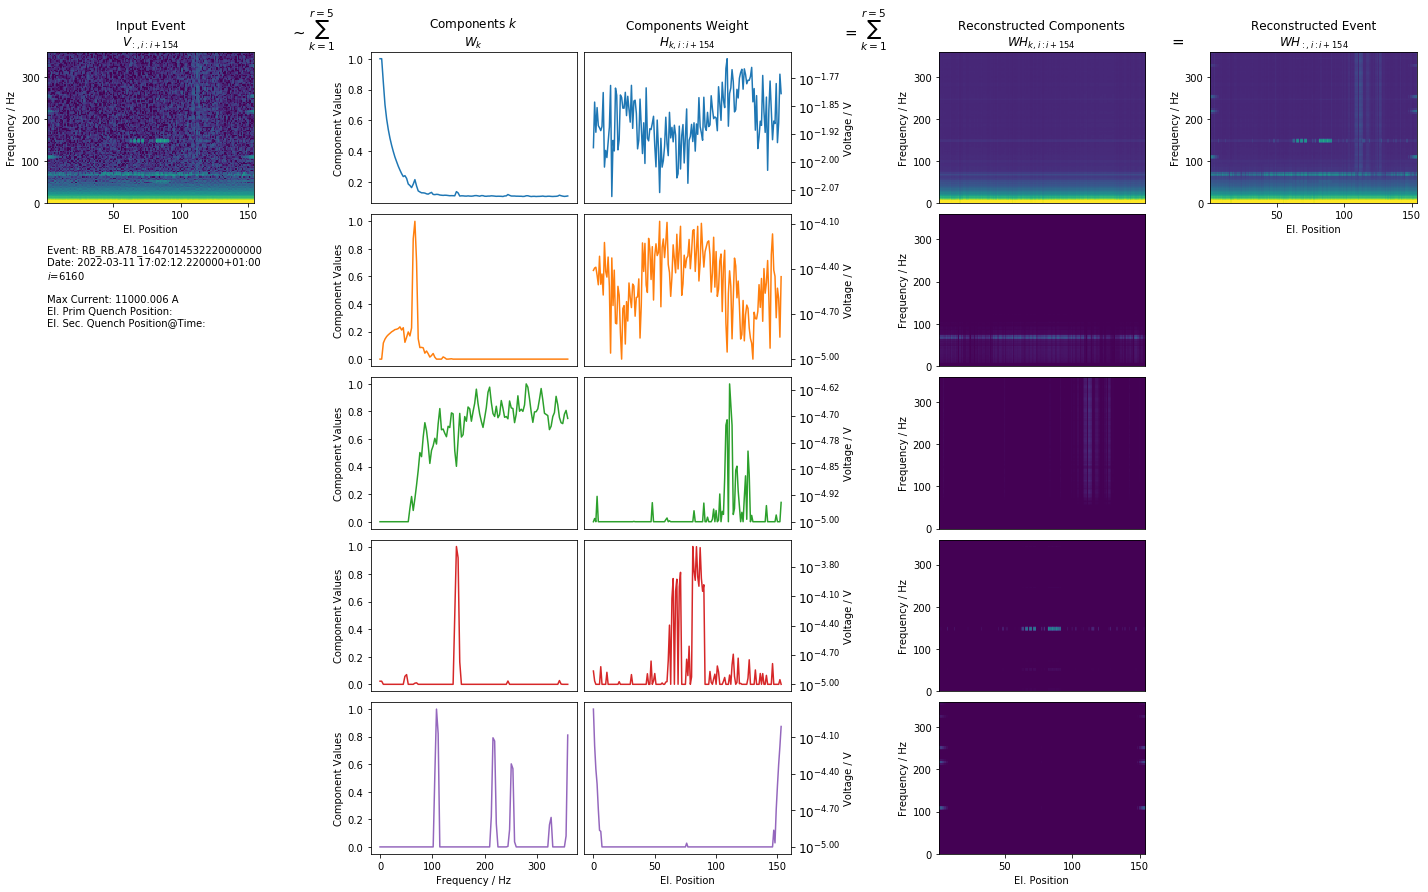

In [27]:
component_indexes_1EE = [0,1,3,2,4]
plot_nmf_event_composition(data_1EE, component_weights_1EE, H_1EE_processed, component_indexes_1EE, dataset_1EE_fft, fpa_identifier, mp3_fpa_df)

In [13]:
### Distribution of Component weights

In [23]:
component_weights_1EE_reshaped = component_weights_1EE[..., component_indexes_1EE].copy().reshape(-1, 154, n_components)

mp3_fpa_df_subset = mp3_fpa_df[mp3_fpa_df.fpa_identifier.isin(fpa_identifiers)]
mp3_fpa_df_subset[["El. Quench Position",  "Phys. Quench Position"]] = 0
sort_columns = ['El. Position', 'Phys. Position', 'Phys. Dist. to PC']

c_weights_dict = generate_sorted_value_dict(values=component_weights_1EE_reshaped, df_pos_map=df_pos_map, df_event_context=mp3_fpa_df_subset, sort_columns=sort_columns)

El. Position
Phys. Position
Phys. Dist. to PC


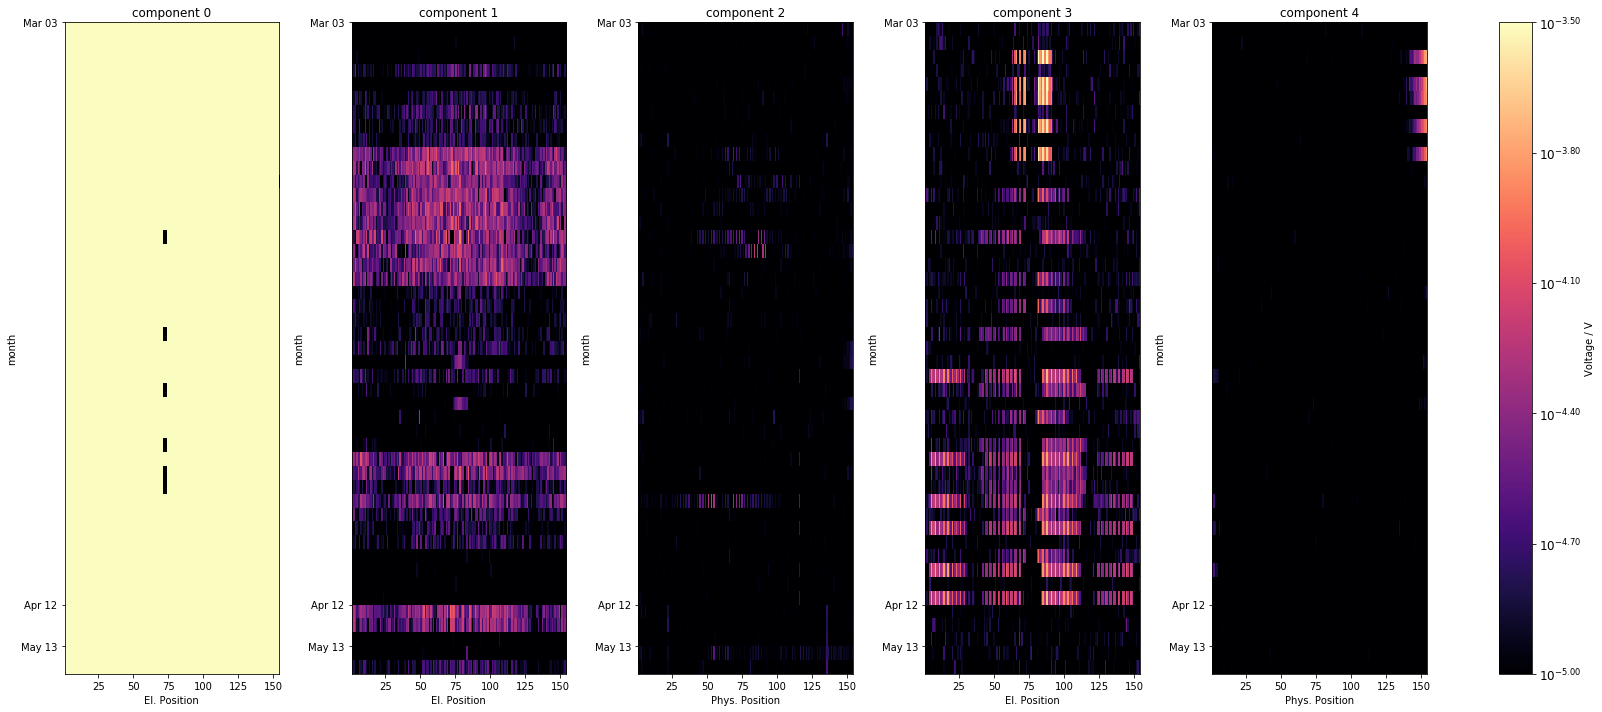

In [29]:
plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort=["datetime"], event_sort_ticks="month", is_date=True)

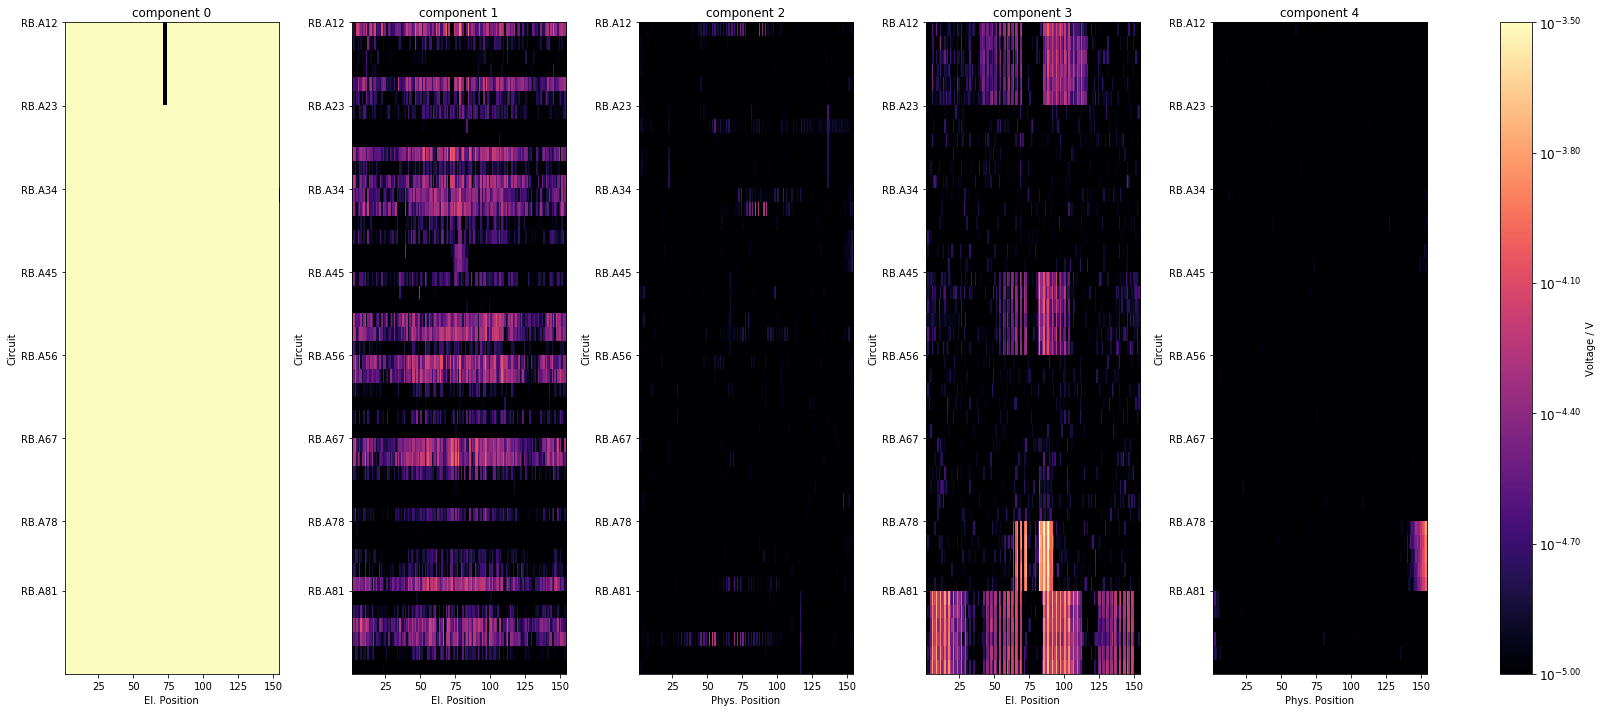

In [30]:
plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort=["Circuit"], event_sort_ticks="Circuit", is_date=False)

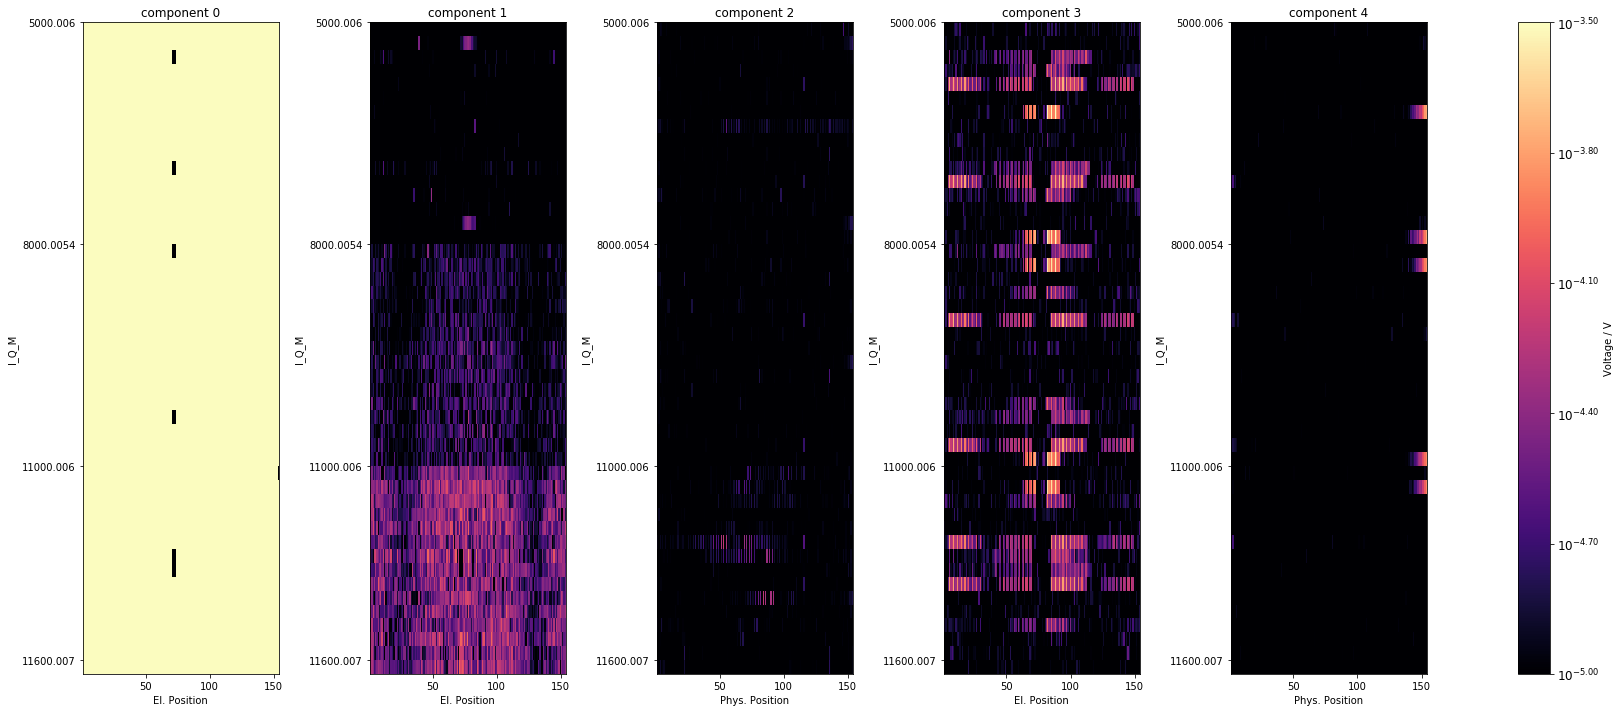

In [16]:
plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort="I_Q_M", event_sort_ticks="I_Q_kA", is_date=False)

# Distribution over Sector

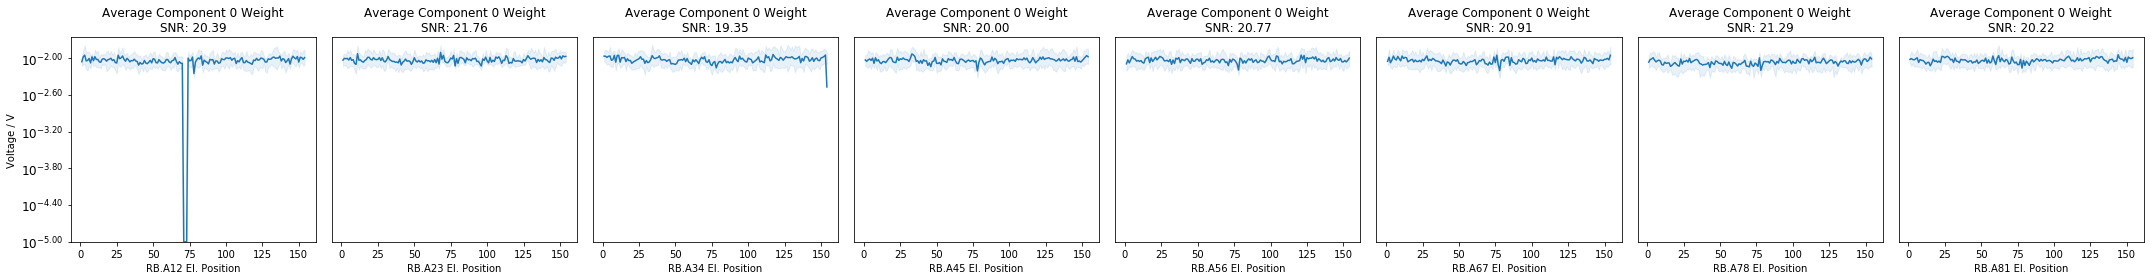

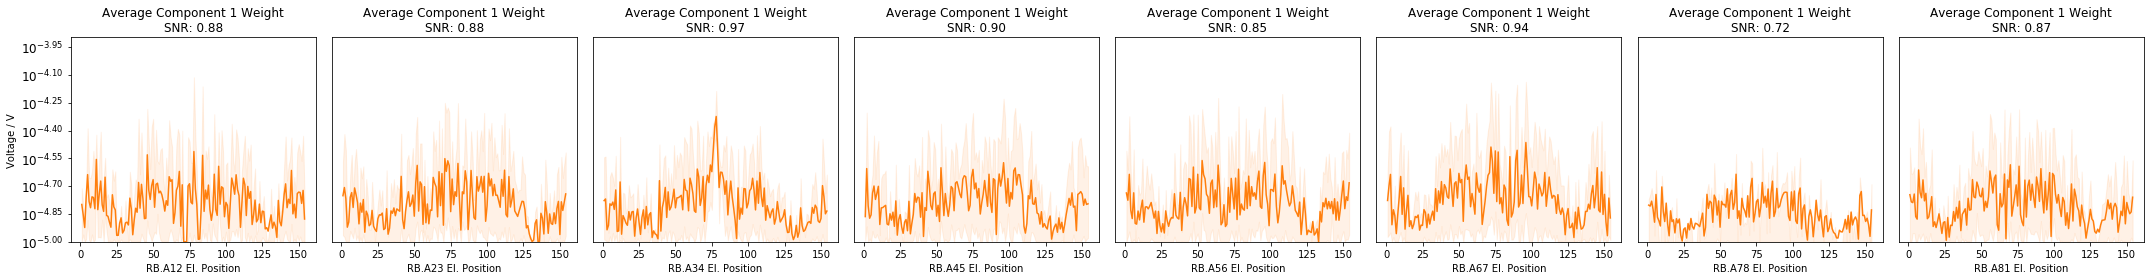

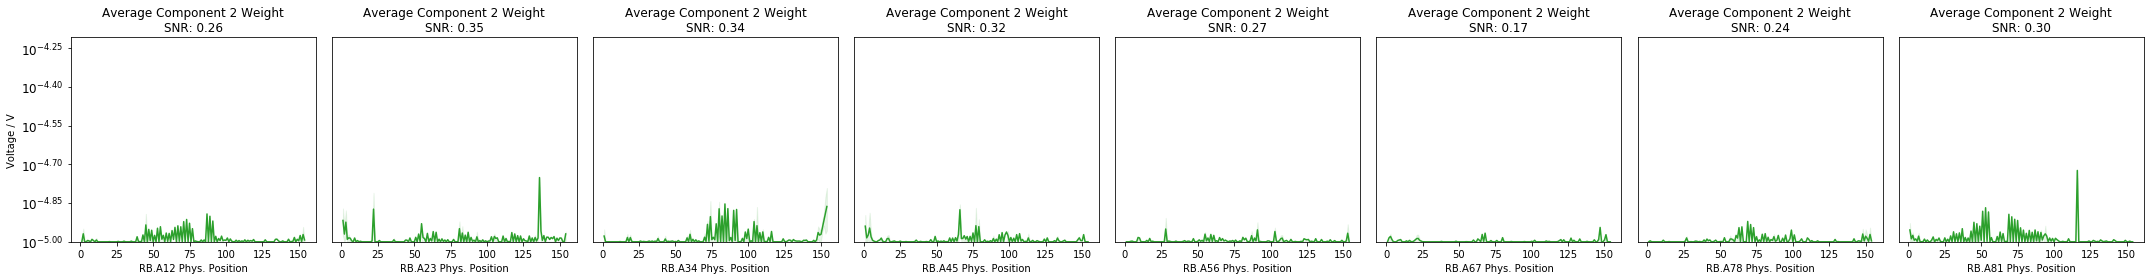

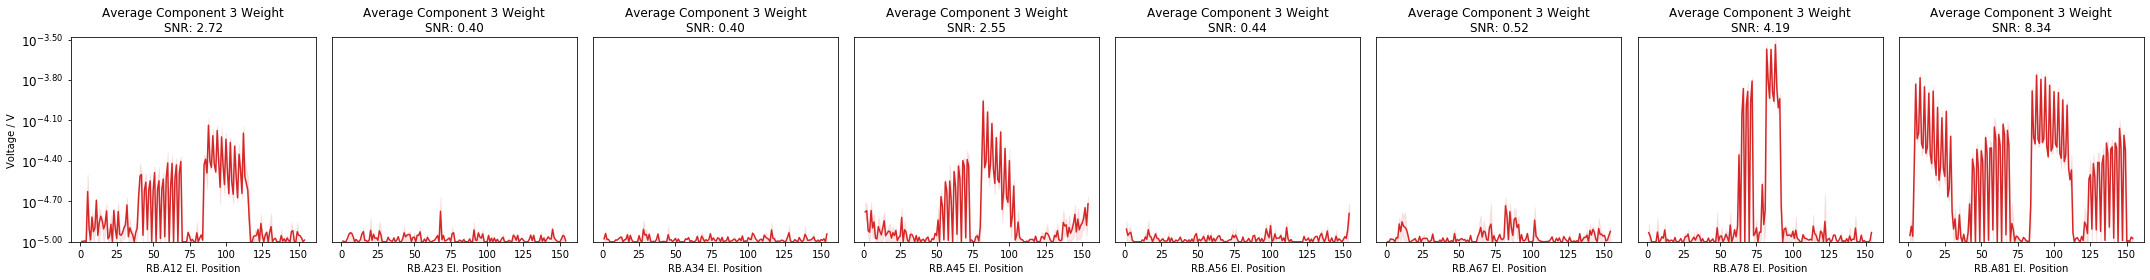

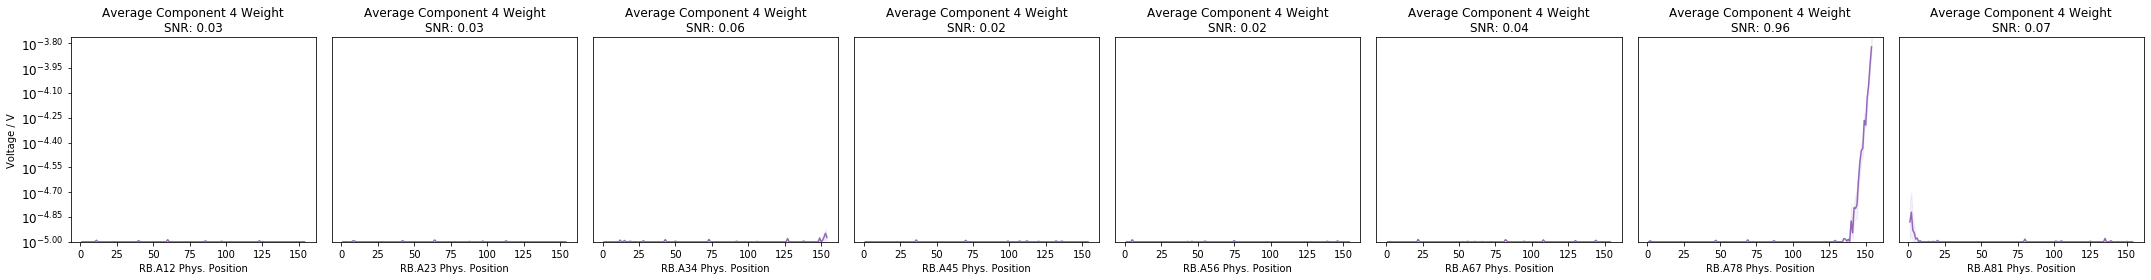

In [17]:
for k in range(n_components): 
    snr_sorted_index = np.argsort([-c_weights_dict[sort]["snr"][k] for sort in c_weights_dict])[0]
    
    fig, ax = plt.subplots(1,8, figsize =(30,4))
    sort = np.array(list(c_weights_dict))[snr_sorted_index]
    
    data = c_weights_dict[sort]["values"][..., k]
    y_max = data[np.isfinite(data)].max()
    
    for i, circuit in enumerate(rb_magnet_metadata.Circuit.unique()):
        circuit_fpa_identifiers = mp3_fpa_df_subset[mp3_fpa_df_subset.Circuit == circuit].fpa_identifier
        circuit_bool = np.isin(fpa_identifiers, circuit_fpa_identifiers)

        circuit_data_dict = {"values": c_weights_dict[sort]["values"][circuit_bool],
                             "index": c_weights_dict[sort]["index"]}

        plot_avg_component_weight(ax[i], circuit_data_dict, component_number=k, xlabel=f"{circuit} {sort}" )

        ax[i].set_ylim((0,y_max)) 
        if i == 0:
            yticks = ax[i].get_yticks().tolist()
            ax[i].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
            ax[i].set_ylabel("Voltage / V")
        else:
            ax[i].set_yticks([])

    plt.tight_layout()

## 2nd Energy Extraction Plateau

In [18]:
n_components = 4
W_2EE, H_2EE, n_iter = nmf.non_negative_factorization(data_2EE, n_components=n_components, init='nndsvd', tol=1e-3, l1_ratio=0.5,  regularization='both', alpha=1, max_iter=200)

max_H = H_2EE.max(axis=1, keepdims=True)
H_2EE_processed = H_2EE / max_H
component_weights_2EE = (W_2EE * np.expand_dims(max_H.T, axis=0))[0]

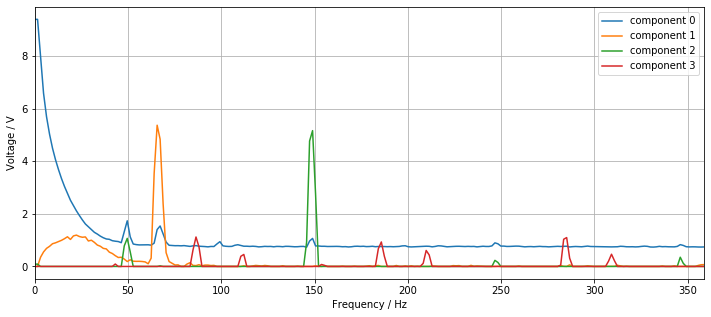

In [19]:
plot_nmf_components(H_2EE, dataset_2EE_fft)

### Check components

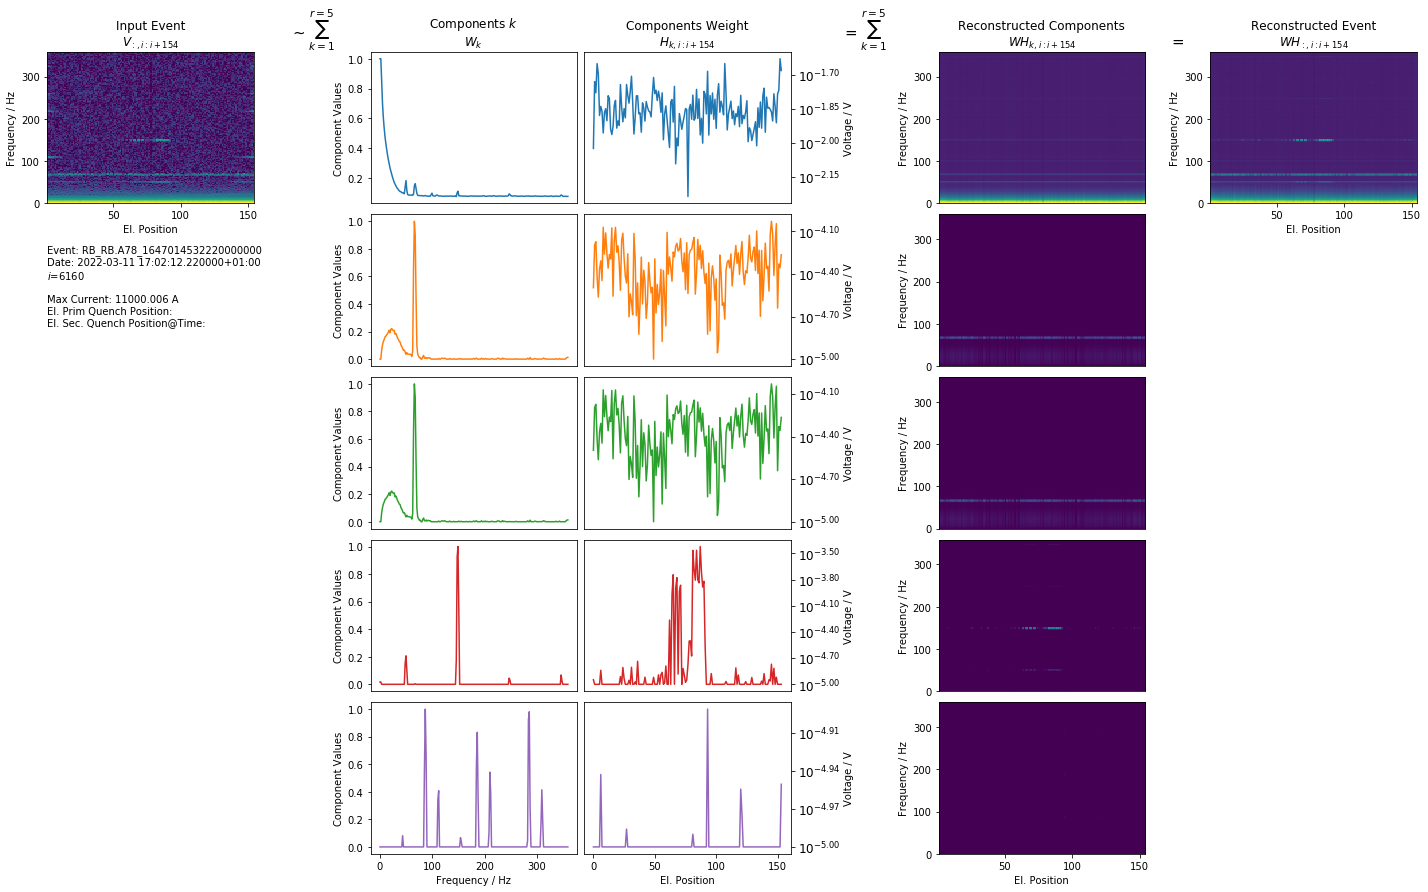

In [20]:
component_indexes_2EE = [0, 1,1,2,3]
plot_nmf_event_composition(data_2EE, component_weights_2EE, H_2EE_processed, component_indexes_2EE, dataset_2EE_fft, fpa_identifier, mp3_fpa_df)

In [21]:
component_weights_2EE_reshaped = component_weights_2EE[..., component_indexes_2EE].copy().reshape(-1, 154, len(component_indexes_2EE))

c_weights_dict = generate_sorted_value_dict(values=component_weights_2EE_reshaped, df_pos_map=df_pos_map, df_event_context=mp3_fpa_df_subset, sort_columns=sort_columns)

El. Position
Phys. Position
Phys. Dist. to PC


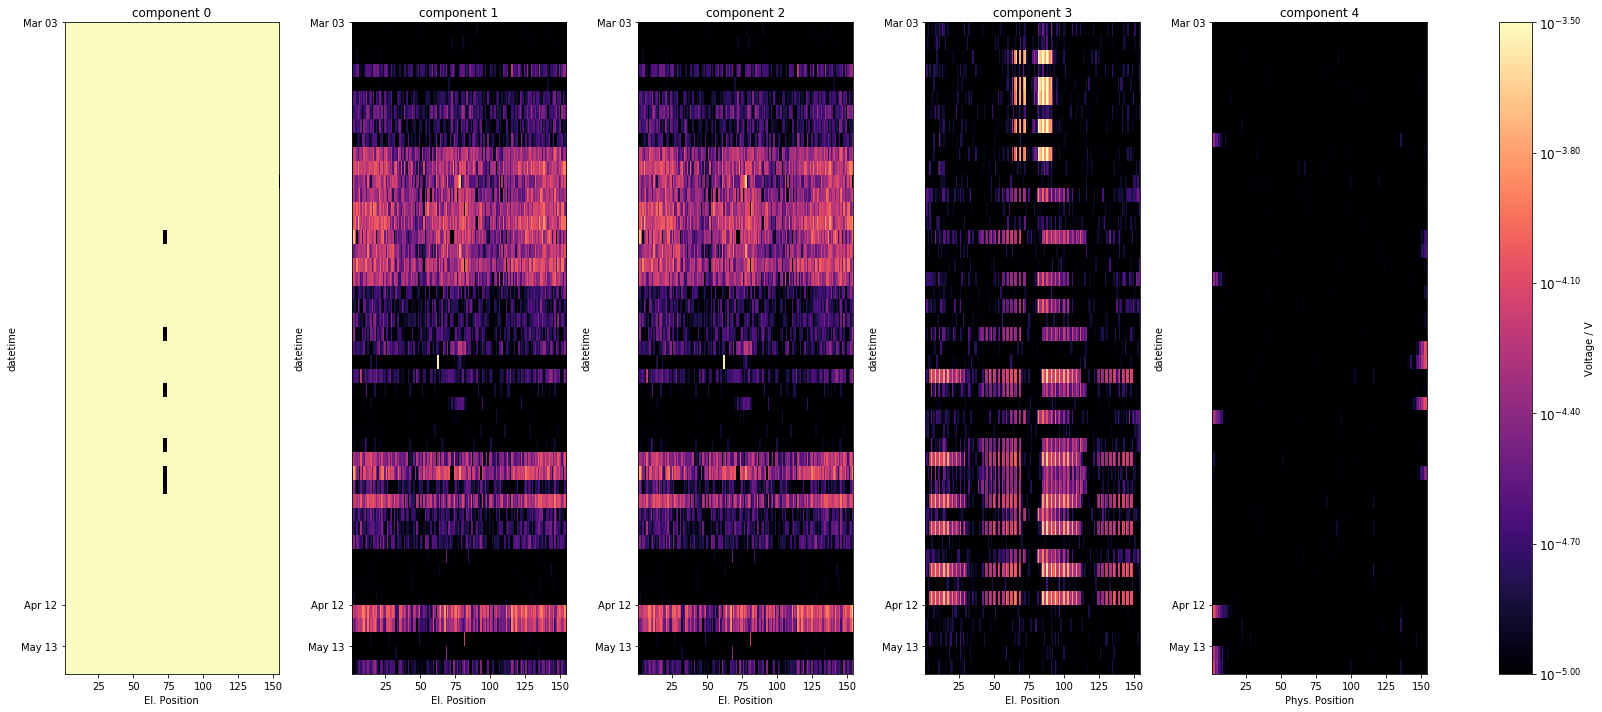

In [22]:
plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort="datetime", event_sort_ticks="month", is_date=True)

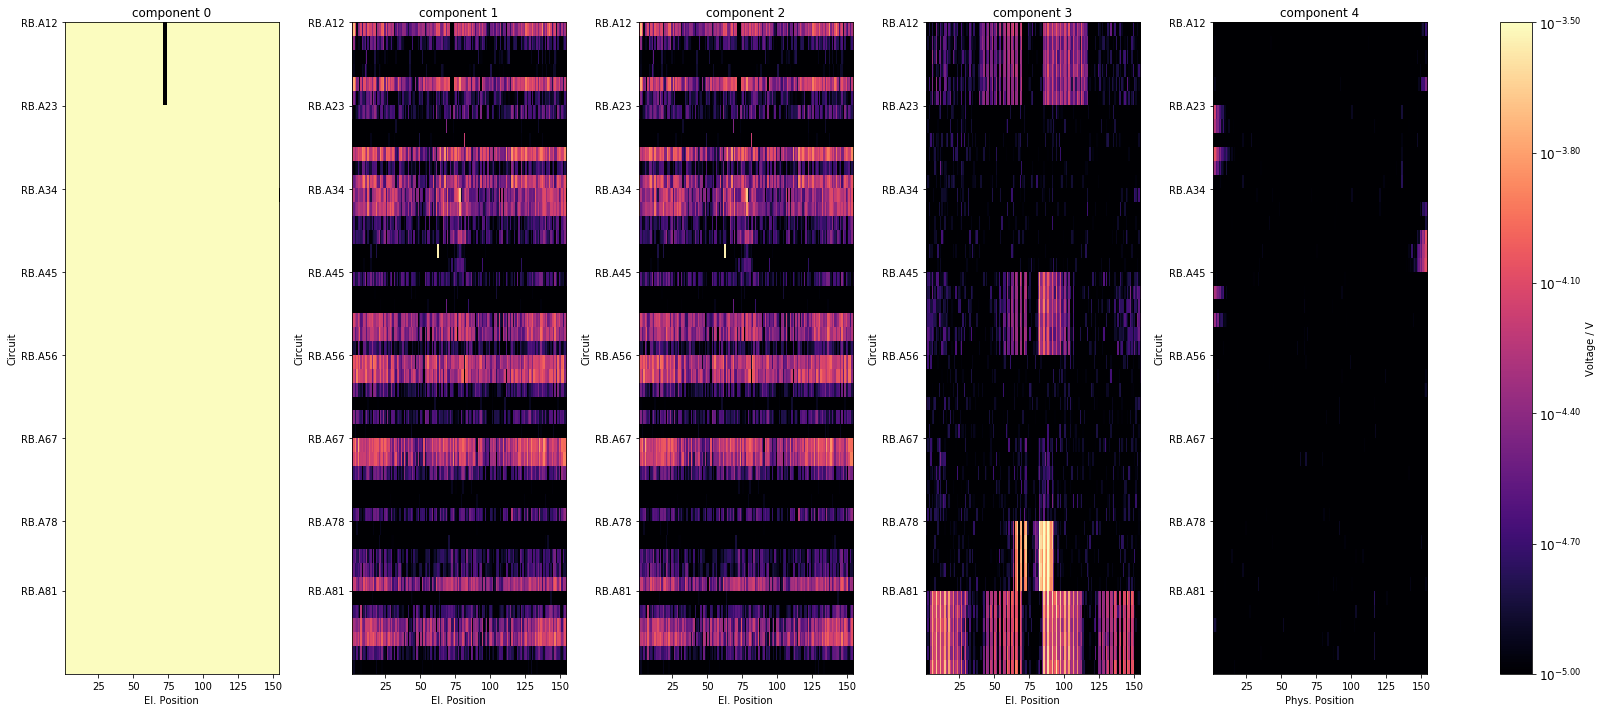

In [23]:
plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort="Circuit", event_sort_ticks="Circuit", is_date=False)

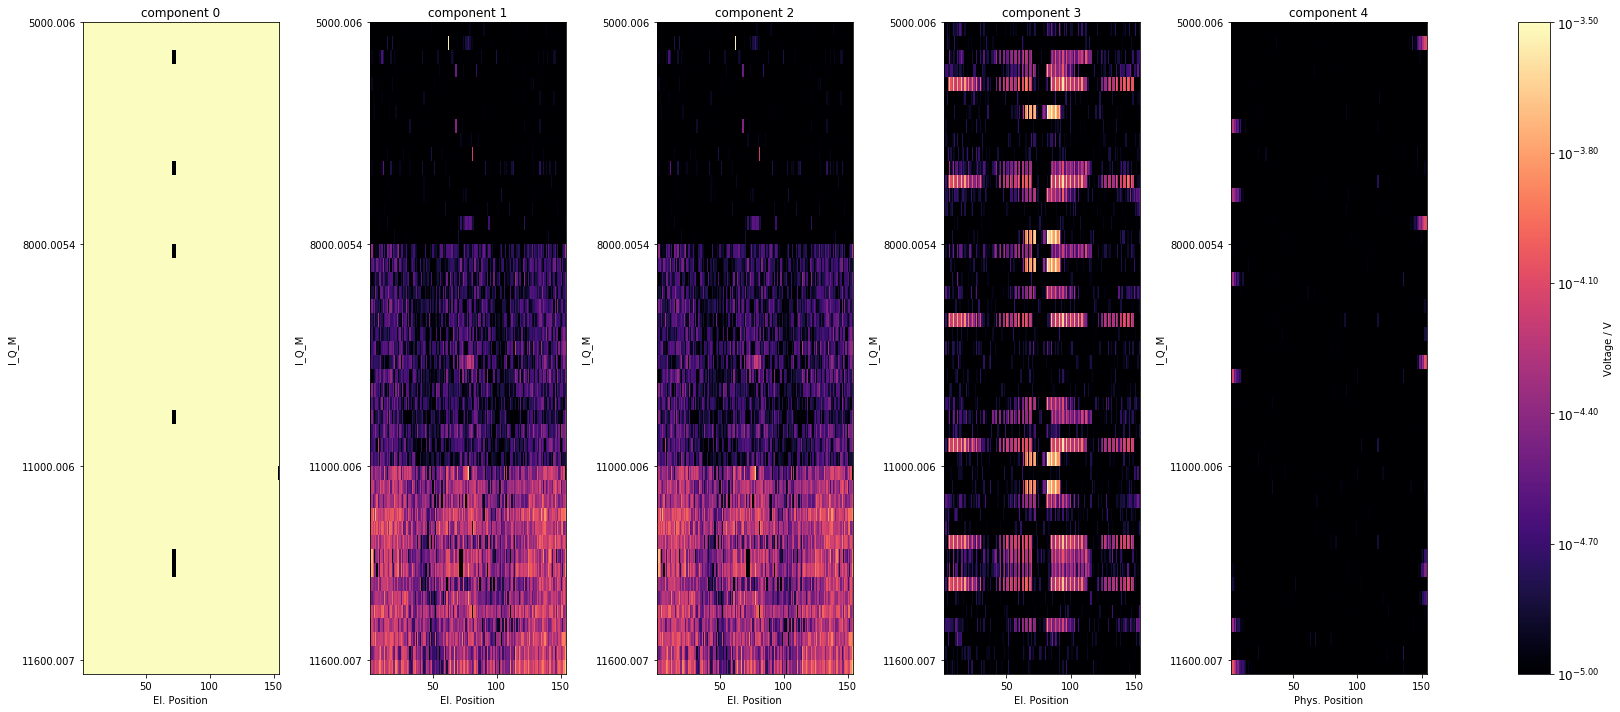

In [24]:
plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort="I_Q_M", event_sort_ticks="I_Q_kA", is_date=False)

In [25]:
def plot_component_distribution(c_weights_dict, mp3_fpa_df_subset, event_sort, event_sort_ticks, is_date=False):
    n_components = c_weights_dict["El. Position"]["values"].shape[-1]

    mp3_fpa_df_sorted = mp3_fpa_df_subset.reset_index(drop=True).sort_values(by=event_sort)
    event_sort_index = mp3_fpa_df_sorted.index.values
    mp3_fpa_df_sorted = mp3_fpa_df_sorted.reset_index()
    
    first_entry_df = mp3_fpa_df_sorted[event_sort_ticks].drop_duplicates()
    y_tick_index = first_entry_df.index.values 
    yticklabels = mp3_fpa_df_sorted.iloc[y_tick_index][event_sort]
    if is_date:
        yticklabels = yticklabels.apply(lambda x: x.strftime(format='%b %d'))
        
    fig, ax = plt.subplots(1, (n_components+1), figsize =(4*(n_components+1),10))
    for n in range(n_components):
        snr_sorted_index = np.argsort([-c_weights_dict[sort]["snr"][n] for sort in c_weights_dict])[0]
        position_sort = np.array(list(c_weights_dict))[snr_sorted_index]
        
        extent = [1, 154, len(mp3_fpa_df_sorted), 0]

        ax[n].set_title(f"component {n}")
        im = ax[n].imshow(c_weights_dict[position_sort]["values"][event_sort_index,:, n], extent=extent, cmap="magma", origin="upper", aspect="auto", vmin=0, vmax=0.5)
        ax[n].set_xlabel(f"{position_sort}")
        ax[n].set_ylabel(f"{event_sort}")

        ax[n].set_yticks(y_tick_index[::-1])
        ax[n].set_yticklabels(yticklabels[::-1])
        
    cbar = fig.colorbar(im, ax=ax[-1], fraction=1)
    cbar.set_label('Voltage / V')
    ax[-1].set_axis_off()
    cticks = cbar.get_ticks().tolist()
    cbar.set_ticks(cticks)
    cbar.set_ticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in cticks])
    cbar.ax.tick_params(labelsize=12)
    
    plt.tight_layout()

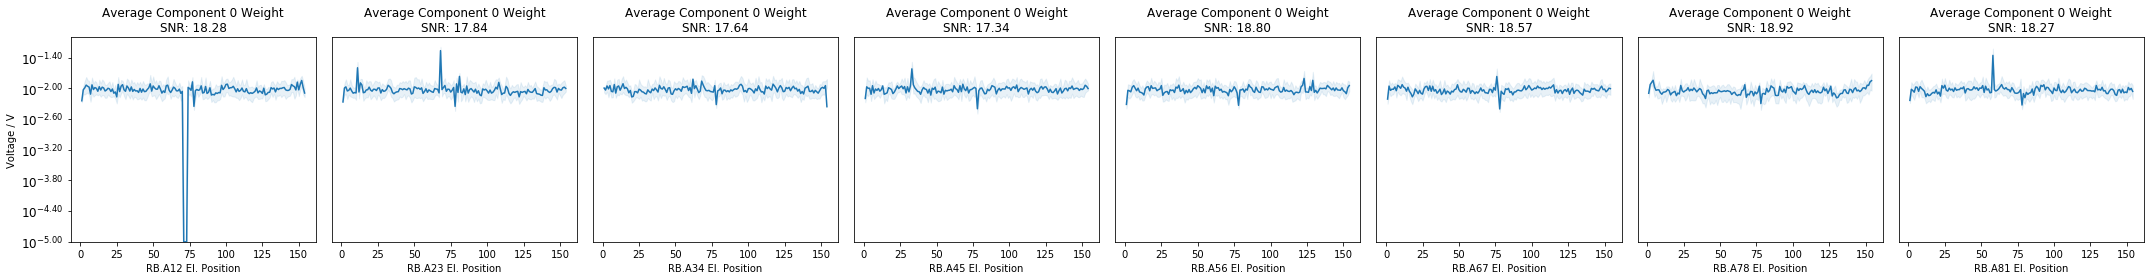

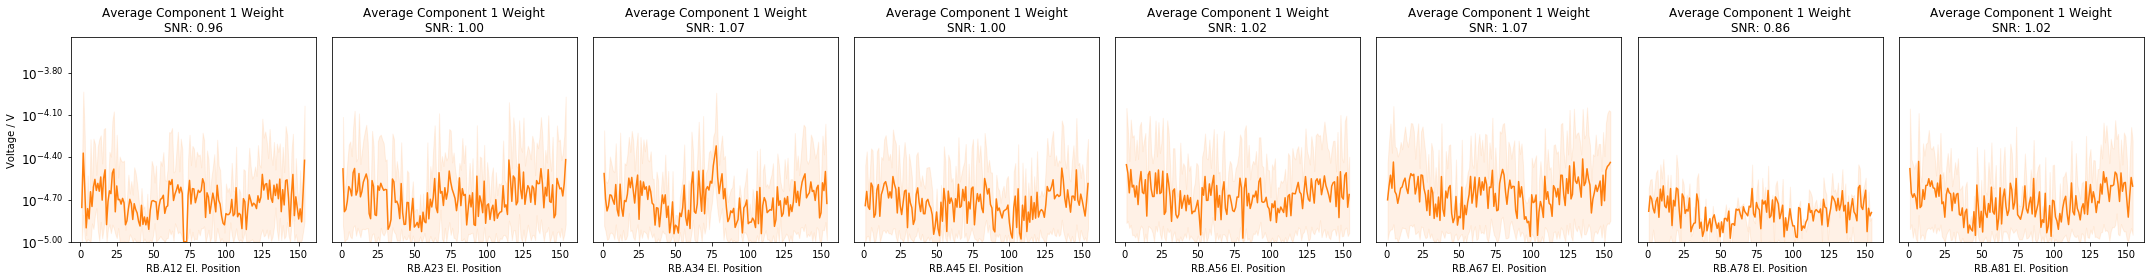

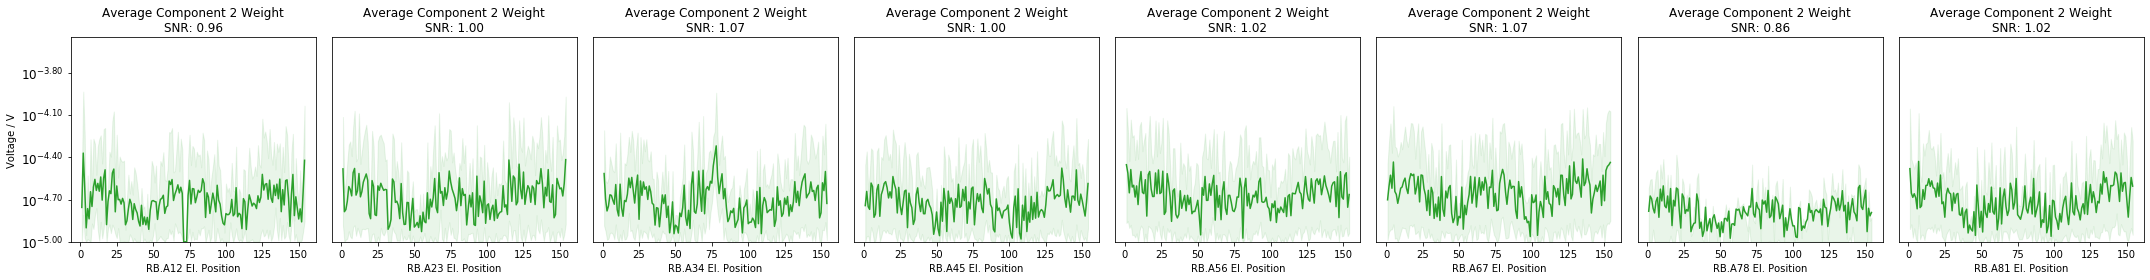

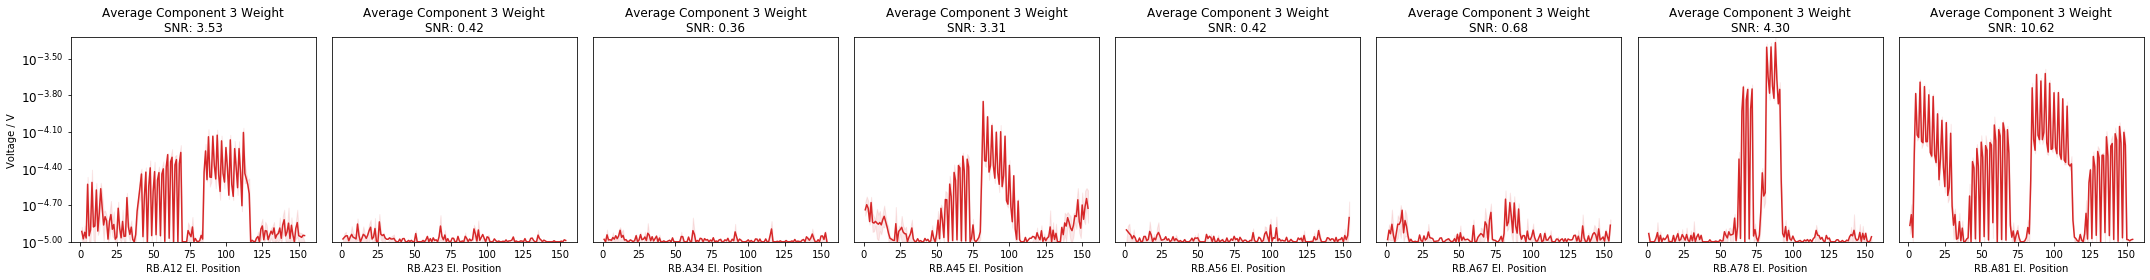

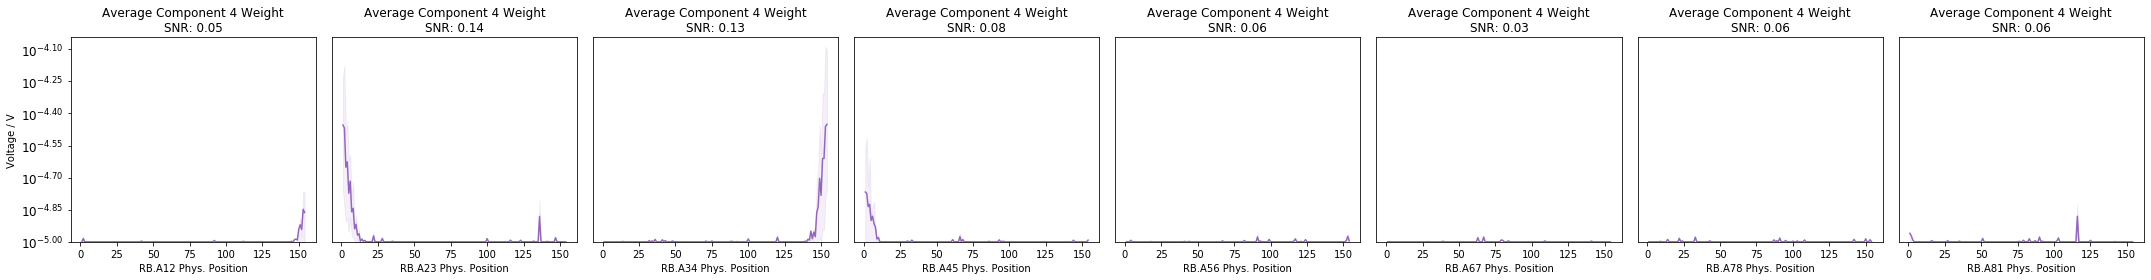

In [26]:
for k in range(len(component_indexes_2EE)): 
    snr_sorted_index = np.argsort([-c_weights_dict[sort]["snr"][k] for sort in c_weights_dict])[0]
    
    fig, ax = plt.subplots(1,8, figsize =(30,4))
    sort = np.array(list(c_weights_dict))[snr_sorted_index]
    
    data = c_weights_dict[sort]["values"][..., k]
    y_max = data[np.isfinite(data)].max()
    
    for i, circuit in enumerate(rb_magnet_metadata.Circuit.unique()):
        circuit_fpa_identifiers = mp3_fpa_df_subset[mp3_fpa_df_subset.Circuit == circuit].fpa_identifier
        circuit_bool = np.isin(fpa_identifiers, circuit_fpa_identifiers)

        circuit_data_dict = {"values": c_weights_dict[sort]["values"][circuit_bool],
                             "index": c_weights_dict[sort]["index"]}

        plot_avg_component_weight(ax[i], circuit_data_dict, component_number=k, xlabel=f"{circuit} {sort}" )

        ax[i].set_ylim((0,y_max)) 
        if i == 0:
            yticks = ax[i].get_yticks().tolist()
            ax[i].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
            ax[i].set_ylabel("Voltage / V")
        else:
            ax[i].set_yticks([])

    plt.tight_layout()